# Библы

In [ ]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
import operator
import sys
import pickle
import random
import sklearn
import seaborn as sns #visualisation
%matplotlib inline 
sns.set(color_codes=True)
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Арифметические операции

In [ ]:
class matr(object):

    def __init__(self, n, m, init=True):
        if init:
            self.rows = [[0]*m for x in range(n)]
        else:
            self.rows = []
        self.m = m
        self.n = n

    def shape(self):
      return (self.n,self.m)

    # getitem TODO
    def __getitem__(self, idx):
        return self.rows[idx]

    # по индексу
    def __setitem__(self, idx, item):
        self.rows[idx] = item

    def __str__(self):
        s='\n'.join([' '.join([str(item) for item in row]) for row in self.rows])
        return s + '\n'

    def transpose(self):
        """ Transpose the matrix. Changes the current matrix """

        self.m, self.n = self.n, self.m
        self.rows = [list(item) for item in zip(*self.rows)]

    def get_transpose(self):
        """ Return a transpose of the matrix without
        modifying the matrix itself """

        m, n = self.n, self.m
        mat = matr(n, m)
        mat.rows =  [list(item) for item in zip(*self.rows)]

        return mat

    def get_rank(self):
        return (self.m, self.n)

    def __eq__(self, mat):
        return (mat.rows == self.rows)

    def __add__(self, mat):
        # Случай добавления числа
        if isinstance(mat, matr) == False:
            res = matr(self.n, self.m)

            for x in range(self.n):
                row = [i+mat for i in self.rows[x]]
                res[x] = row

            return res

        res = matr(self.n, self.m)

        for x in range(self.n):
            row = [sum(i) for i in zip(self.rows[x], mat[x])]
            res[x] = row

        return res
    
    def __pow__(self, val):
        res = matr(self.n, self.m)
        for x in range(self.n):
          row = [i**val for i in self.rows[x]]
          res[x] = row
        
        return res

    def __sub__(self, mat):
        # Случай добавления числа
        if isinstance(mat, matr) == False:
            res = matr(self.n, self.m)

            for x in range(self.n):
                row = [i-mat for i in self.rows[x]]
                res[x] = row

            return res

        res = matr(self.n, self.m)

        for x in range(self.n):
            row = [i[0]-i[1] for i in zip(self.rows[x], mat[x])]
            res[x] = row

        return res
    def __rsub__(self, mat):
        # Случай добавления числа
        if isinstance(mat, matr) == False:
            res = matr(self.n, self.m)

            for x in range(self.n):
                row = [mat-i for i in self.rows[x]]
                res[x] = row

            return res

        return None
    # Предполагаем что единственное деление которое нам нужно будет
    # производить это деление матрицы на число
    def __truediv__(self, mat):
        if isinstance(mat, matr) == False:
          res = matr(self.n, self.m)

          for x in range(self.n):
              row = [i/mat for i in self.rows[x]]
              res[x] = row

          return res
        
        # Иногда нужно еще делить вектор на вектор поэлементно
        res = matr(self.n, self.m)
        for x in range(self.m):
          res[0][x] = self.rows[0][x]/mat.rows[0][x]
        return res

    # TODO - faster multiplication mabe?
    def __mul__(self, mat):
        # Случай умножения на число
        if isinstance(mat, matr) == False:
            res = matr(self.n, self.m)

            for x in range(self.n):
                row = [i*mat for i in self.rows[x]]
                res[x] = row

            return res
        # Матрица на матрицу
        matn, matm = mat.get_rank()
        tmpmat = mat.get_transpose()
        matmul = matr(self.n, matn)

        for x in range(self.n):
            for y in range(tmpmat.n):
                matmul[x][y] = sum([item[0]*item[1] for item in zip(self.rows[x], tmpmat[y])])

        return matmul
    def __rmul__(self, mat):
        # Случай умножения на число
        if isinstance(mat, matr) == False:
            res = matr(self.n, self.m)

            for x in range(self.n):
                row = [i*mat for i in self.rows[x]]
                res[x] = row

            return res
        # Матрица на матрицу не должна быть
        
        return None

    #
    # Операции со строками. в двух вариациях с изменением рабочей матрицы и без
    #

    def row_add(self, row_num, val):
        self.rows[row_num] = [self.rows[row_num][i]+val for i in range(self.m)]
    def row_div(self, row_num, val):
        self.rows[row_num] = [self.rows[row_num][i]/val for i in range(self.m)]
    def row_mul(self, row_num, val):
        self.rows[row_num] = [self.rows[row_num][i]*val for i in range(self.m)]
    def row_sub(self, row_num, val):
        self.rows[row_num] = [self.rows[row_num][i]-val for i in range(self.m)]

    def get_row_add(self, row_num, val):
        mat = self
        mat.rows[row_num] = [self.rows[row_num][i]+val for i in range(self.m)]
        return mat
    def get_row_div(self, row_num, val):
        mat = self
        mat.rows[row_num] = [self.rows[row_num][i]/val for i in range(self.m)]
        return mat
    def get_row_mul(self, row_num, val):
        mat = self
        mat.rows[row_num] = [self.rows[row_num][i]*val for i in range(self.m)]
        return mat
    def get_row_sub(self, row_num, val):
        mat = self
        mat.rows[row_num] = [self.rows[row_num][i]-val for i in range(self.m)]
        return mat

    # Среднее значение по солбцам матрицы
    # cls -> self?
    def unimean(cls):
        n = len(cls.rows)
        m = len(cls.rows[0])

        mat = matr(n, m)
        mat.rows =  [list(item) for item in zip(*cls.rows)]

        uni = [[sum(i)/float(m) for i in mat.rows]]
        #for i in range(m):
         #   uni.append(sum(rows[i])/n)

        return matr.fromList(uni)

    # Добавление солбца единиц справа соответственно
    def add_ones(self):
        res = matr(self.n, self.m+1, False)
        for i in range(self.n):
          #res.rows.append(self.rows[i])
          cl = []
          cl.extend(self.rows[i])
          cl.append(1)
          res.rows.append(cl)
        return res
    # Поиск обратной матрицы методом Гаусса
    def get_inverted(clc):
        n = len(clc.rows)
        m = len(clc.rows[0])

        a = matr(n,m*2)

        a.rows = [i+[0]*m for i in clc.rows]
        for i in range(n):
            a[i][m+i] = 1

        #Applying Guass Jordan Elimination
        for i in range(m):
            if a[i][i] == 0.0:
                sys.exit('Divide by zero detected!')

            for j in range(m):
                if i != j:
                    ratio = a[j][i]/float(a[i][i])
                    for k in range(2*m):
                        a[j][k] = a[j][k] - ratio * a[i][k]
        # Row operation to make principal diagonal element to 1
        for i in range(m):
            divisor = a[i][i]
            for j in range(2*m):
                a[i][j] = a[i][j]/float(divisor)


        inverted = matr(n,m)
        inverted.rows = [i[m:] for i in a.rows]

        return inverted

    # Add another way of saving
    def save_obj(cls, name ):
        with open('obj/'+ name + '.pkl', 'wb') as f:
            pickle.dump(cls, f, pickle.HIGHEST_PROTOCOL)

    @classmethod
    # Redo load mechanism
    def load_obj(cls, name):
        with open('obj/' + name + '.pkl', 'rb') as f:
            return pickle.load(f)

    # def loat_to_cls(name):

    @classmethod
    def _makematr(cls, rows):

        n = len(rows)
        m = len(rows[0])

        mat = matr(n,m, init=False)
        mat.rows = rows

        return mat

    @classmethod
    # случайная матрица получаемая с использованием random
    def make_random(cls, n, m, low=0, high=10):

        obj = matr(n, m, init=False)
        for x in range(n):
            obj.rows.append([random.randrange(low, high) for i in range(obj.m)])

        return obj

    @classmethod
    def make_zero(cls, n, m):
        rows = [[0]*m for x in range(n)]
        return cls.fromList(rows)

    @classmethod
    # создает единичную матрицу размера nxn
    def make_identity(cls, n):
        rows = [[0]*n for x in range(n)]
        idx = 0

        for row in rows:
            row[idx] = 1
            idx += 1

        return cls.fromList(rows)

    @classmethod
    # для создания матрицы из листа листов
    def fromList(cls, listoflists):
        # E.g: matr.fromList([[1 2 3], [4,5,6], [7,8,9]])

        rows = listoflists[:]
        return cls._makematr(rows)


# Регрессия

In [ ]:
class Linreg_MSE:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):     
        n, m = X.n, X.m
        
        X_train = X
        if self.fit_intercept:
            X_train = X_train.add_ones()
            

        # w = (XT*X)−1*XT*Y
        
        xtx = X_train.get_transpose()*X_train
        xtx_inv = xtx.get_inverted()
        self.w = xtx_inv*X_train.get_transpose()*y.get_transpose()
        self.w = self.w.get_transpose()
        return self
        
    def predict(self, X):
        n, m = X.n, X.m
        
        X_train = X
        if self.fit_intercept:
            X_train = X_train.add_ones()
        y_pred = X_train * self.w.get_transpose()

        return y_pred.get_transpose()
    
    def get_weights(self):
        return self.w

class Linreg_Gradient(Linreg_MSE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None
    
    def fit(self, X, y, lr=0.001, max_iter=100):
        n, k = X.n, X.m

        if self.w is None:
            self.w = matr.make_random(1, k + 1 if self.fit_intercept else k)
        X_train = X.add_ones() if self.fit_intercept else X
        
        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            #print(self.w.shape())
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape() == self.w.shape(), f"gradient shape {grad.shape()} is not equal weight shape {self.w.shape()}"
            self.w = self.w - lr*grad

        return self

    def _calc_gradient(self, X, y, y_pred):
        dy = (y_pred - y)*2.
        grad = dy*X

        return grad.unimean()

    def get_losses(self):
        return self.losses

class Linreg_SGD(Linreg_Gradient):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.n), size=self.n_sample, replace=False)
        
        r_grad = [[]]
        for i in inds:
          r_grad[0].append(2*(y_pred[0][i] - y[0][i]))
        grad_r = matr.fromList(r_grad)
        X_inds = matr(self.n_sample, X.m, False)
        XIrows = []
        for i in inds:
          XIrows.append(X.rows[i])
        X_inds.rows = XIrows
        #print(grad_r)
        #print(X_inds)

        #grad = grad*X_inds
        grad = matr(self.n_sample,X.m)
        for i in range(self.n_sample):
          #grad[i] = grad_r[0][i]*X_inds.rows[i]
          grad[i] = [z*grad_r[0][i] for z in X_inds.rows[i]]
        
        return grad.unimean()

#AdaGrad
class Linreg_AdaGrad(Linreg_SGD):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100, eps = 1e-6):
        n, k = X.shape()
        
        if self.w is None:
            self.w = matr.make_random(1, k + 1 if self.fit_intercept else k)
        
        X_train = X.add_ones() if self.fit_intercept else X
        
        gti = matr.make_zero(1,k + 1 if self.fit_intercept else k)

        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape() == self.w.shape(), f"gradient shape {grad.shape()} is not equal weight shape {self.w.shape()}"

           
            gti = gti + grad**2
            adj_grad = grad / (gti + eps)**0.5
            self.w = self.w - lr * adj_grad
        print("w = ", self.w)
        return self

#RMSProp
class Linreg_RMSProp(Linreg_SGD):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100, beta = 0.6, eps = 1e-8):
        n, k = X.shape()

        if self.w is None:
            self.w = matr.make_random(1, k + 1 if self.fit_intercept else k)
        
        X_train = X.add_ones() if self.fit_intercept else X
        
        gti = matr.make_zero(1,k + 1 if self.fit_intercept else k)

        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape() == self.w.shape(), f"gradient shape {grad.shape()} is not equal weight shape {self.w.shape()}"

            gti = beta * gti + (1-beta) * grad**2
            adj_grad = grad / (gti + eps)**0.5
            self.w = self.w - lr * adj_grad

        return self

#Adam
class Linreg_Adam(Linreg_SGD):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None

    def fit(self, X, y, lr=0.001, max_iter=100, beta1 = 0.9, beta2 = 0.99, eps = 1e-8):
        n, k = X.shape()

        if self.w is None:
            self.w = matr.make_random(1, k + 1 if self.fit_intercept else k)
        
        X_train = X.add_ones() if self.fit_intercept else X
        
        #gti = matr.make_zero(0,k + 1 if self.fit_intercept else k)
        m_w = matr.make_zero(1, k + 1 if self.fit_intercept else k)
        v_w = matr.make_zero(1, k + 1 if self.fit_intercept else k)

        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape() == self.w.shape(), f"gradient shape {grad.shape()} is not equal weight shape {self.w.shape()}"

            m_w = beta1 * m_w + (1-beta1) * grad
            v_w = beta2 * v_w + (1-beta2) * grad**2
            m_w = m_w / (1-beta1**(iter_num+1))
            v_w = v_w / (1-beta2**(iter_num+1))
            self.w = self.w - lr * m_w/(v_w + eps)**0.5

        return self

#L1
class Linreg_L1(Linreg_SGD):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.n), size=self.n_sample, replace=False)

        signw_rows = [np.sign(self.w.rows[0])]

        if self.fit_intercept:
            signw_rows[0][-1] = 0
        signw = matr.fromList(signw_rows)
        
        r_grad = [[]]
        for i in inds:
          r_grad[0].append(y_pred[0][i] - y[0][i])
        grad_r = matr.fromList(r_grad)
        X_inds = matr(self.n_sample, X.m, False)
        XIrows = []
        for i in inds:
          XIrows.append(X.rows[i])
        X_inds.rows = XIrows

        grad = matr(X.m,1)
        grad = grad+ X_inds.get_transpose()*grad_r.get_transpose()/self.n_sample
        grad.transpose()
        grad = grad + self.alpha * signw
        
        return grad

#L2
class Linreg_L2(Linreg_SGD):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) 
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.n), size=self.n_sample, replace=False)

        #lambdaI = self.alpha * np.eye(self.w.shape[0])
        lambdaI = self.alpha*matr.make_identity(self.w.m)
        
        if self.fit_intercept:
            lambdaI[-1][-1] = 0
        
        X_inds = matr(self.n_sample, X.m, False)
        XIrows = []
        for i in inds:
          XIrows.append(X.rows[i])
        X_inds.rows = XIrows

        y_inds = matr(1, self.n_sample, False)
        yIrows = [[]]
        for i in inds:
          yIrows[0].append(y[0][i])
        y_inds.rows = yIrows

        #print("2 * (X_inds.get_transpose() * X_inds / self.n_sample)",2 * (X_inds.get_transpose() * X_inds / self.n_sample))
        grad = 2 * (X_inds.get_transpose() * X_inds / self.n_sample + lambdaI) * self.w.get_transpose()
        
        grad = grad - 2 * (X_inds.get_transpose() * y_inds.get_transpose()) / self.n_sample

        return grad.get_transpose()

# MSE
def MSE(pred, test):
    #return np.mean((pred-test)**2)np
    #print(pred.shape())
    #print(test.shape())
    tmp = (pred-test)**2
    return sum(tmp[0])/pred.m

#R2
def R2(pred, test):

    mean_test = np.full_like(test, sum(test.rows[0])/test.m)
    t1 = (pred - test)**2
    t1_m = sum(t1.rows[0])/pred.m

    t2 = (pred - mean_test)**2
    t2_m = sum(t2.rows[0])/pred.m
    return 1 - t1_m/t2_m    

# Данные

In [ ]:
#from google.colab import files
#files.upload()

Saving data(2).csv to data(2).csv


{'data(2).csv': b',MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,CRS_DEP_TIME,DEP_TIME,TAXI_OUT,TAXI_IN,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME\n0,9.0,28.0,3.0,0,1055.0,1047.0,9.0,7.0,79.0,68.0\n1,4.0,14.0,4.0,1,705.0,700.0,13.0,7.0,65.0,62.0\n2,6.0,6.0,1.0,2,1931.0,1927.0,17.0,5.0,59.0,57.0\n4,5.0,6.0,5.0,1,730.0,724.0,11.0,11.0,175.0,177.0\n5,2.0,12.0,5.0,3,605.0,600.0,18.0,5.0,154.0,152.0\n6,7.0,20.0,3.0,1,1455.0,1620.0,8.0,10.0,70.0,70.0\n7,9.0,2.0,5.0,2,1526.0,1522.0,16.0,6.0,74.0,65.0\n8,2.0,8.0,1.0,4,645.0,651.0,16.0,11.0,172.0,136.0\n10,2.0,16.0,2.0,6,1246.0,1237.0,14.0,12.0,122.0,114.0\n11,1.0,3.0,7.0,2,1130.0,1134.0,17.0,9.0,195.0,176.0\n12,4.0,11.0,1.0,2,1956.0,1951.0,14.0,3.0,138.0,126.0\n13,9.0,4.0,7.0,1,1535.0,1531.0,10.0,6.0,130.0,118.0\n14,6.0,1.0,3.0,1,1905.0,1913.0,7.0,3.0,145.0,140.0\n16,4.0,1.0,5.0,2,840.0,900.0,13.0,6.0,70.0,56.0\n17,4.0,30.0,6.0,1,1305.0,1406.0,15.0,6.0,230.0,210.0\n18,4.0,13.0,3.0,0,2030.0,2019.0,25.0,5.0,112.0,102.0\n20,7.0,27.0,3.0,6,1050.0,104

In [ ]:
df=pd.read_csv('reg_cut.csv')
df

,Unnamed: 0,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 29,EV,WN,DL,B6,F9,NK,UA,AA,OO,...,HYS,BZN,LIH,BQN,BTV,RNO,MAF,SRQ,SBP,BHM,FLG,ICT,CHO,JLN,EVV,HPN,BFL,VPS,ONT,LEX,CID,KTN,CSG,JNU,MKG,TRI,GJT,WYS,DSM,CAK,MHT,MSO,MFR,ATW,MLU,STX,GGG,EAU,DLH,ILM
0,4889939,2016,9.0,28.0,3.0,EV,N28529,3837.0,LRD,IAH,1055.0,1047.0,-8.0,9.0,7.0,1214.0,1155.0,-19.0,0.0,NaN,0.0,79.0,68.0,52.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1283488,2016,4.0,14.0,4.0,WN,N903WN,696.0,BUR,LAS,705.0,700.0,-5.0,13.0,7.0,810.0,802.0,-8.0,0.0,NaN,0.0,65.0,62.0,42.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2503639,2016,6.0,6.0,1.0,DL,N988DN,2504.0,ATL,HSV,1931.0,1927.0,-4.0,17.0,5.0,1930.0,1924.0,-6.0,0.0,NaN,0.0,59.0,57.0,35.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5550930,2016,2.0,24.0,3.0,DL,N837DN,1680.0,ATL,SFO,1110.0,1108.0,-2.0,25.0,9.0,1338.0,1314.0,-24.0,0.0,NaN,0.0,328.0,306.0,272.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3074268,2016,5.0,6.0,5.0,WN,N463WN,1570.0,ISP,FLL,730.0,724.0,-6.0,11.0,11.0,1025.0,1021.0,-4.0,0.0,NaN,0.0,175.0,177.0,155.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,4134905,2016,11.0,28.0,1.0,DL,N556NW,2128.0,DTW,MCO,1025.0,1023.0,-2.0,15.0,8.0,1307.0,1255.0,-12.0,0.0,NaN,0.0,162.0,152.0,129.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
986,577884,2016,8.0,28.0,7.0,B6,N956JB,1.0,JFK,FLL,1056.0,1057.0,1.0,31.0,6.0,1357.0,1401.0,4.0,0.0,NaN,0.0,181.0,184.0,147.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
987,3380096,2016,3.0,6.0,7.0,AS,N508AS,572.0,PDX,SAN,1200.0,1156.0,-4.0,16.0,3.0,1418.0,1418.0,0.0,0.0,NaN,0.0,138.0,142.0,123.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
988,4967441,2016,9.0,14.0,3.0,AA,N793AA,293.0,JFK,LAX,1720.0,1714.0,-6.0,17.0,7.0,2035.0,2019.0,-16.0,0.0,NaN,0.0,375.0,365.0,341.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = df.sample(n=1000)

In [ ]:
df=df.iloc[0:990,1:30]
df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2016,9.0,28.0,3.0,EV,N28529,3837.0,LRD,IAH,1055.0,1047.0,-8.0,9.0,7.0,1214.0,1155.0,-19.0,0.0,NaN,0.0,79.0,68.0,52.0,2.0,NaN,NaN,NaN,NaN,NaN
1,2016,4.0,14.0,4.0,WN,N903WN,696.0,BUR,LAS,705.0,700.0,-5.0,13.0,7.0,810.0,802.0,-8.0,0.0,NaN,0.0,65.0,62.0,42.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2016,6.0,6.0,1.0,DL,N988DN,2504.0,ATL,HSV,1931.0,1927.0,-4.0,17.0,5.0,1930.0,1924.0,-6.0,0.0,NaN,0.0,59.0,57.0,35.0,1.0,NaN,NaN,NaN,NaN,NaN
3,2016,2.0,24.0,3.0,DL,N837DN,1680.0,ATL,SFO,1110.0,1108.0,-2.0,25.0,9.0,1338.0,1314.0,-24.0,0.0,NaN,0.0,328.0,306.0,272.0,9.0,NaN,NaN,NaN,NaN,NaN
4,2016,5.0,6.0,5.0,WN,N463WN,1570.0,ISP,FLL,730.0,724.0,-6.0,11.0,11.0,1025.0,1021.0,-4.0,0.0,NaN,0.0,175.0,177.0,155.0,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2016,11.0,28.0,1.0,DL,N556NW,2128.0,DTW,MCO,1025.0,1023.0,-2.0,15.0,8.0,1307.0,1255.0,-12.0,0.0,NaN,0.0,162.0,152.0,129.0,4.0,NaN,NaN,NaN,NaN,NaN
986,2016,8.0,28.0,7.0,B6,N956JB,1.0,JFK,FLL,1056.0,1057.0,1.0,31.0,6.0,1357.0,1401.0,4.0,0.0,NaN,0.0,181.0,184.0,147.0,5.0,NaN,NaN,NaN,NaN,NaN
987,2016,3.0,6.0,7.0,AS,N508AS,572.0,PDX,SAN,1200.0,1156.0,-4.0,16.0,3.0,1418.0,1418.0,0.0,0.0,NaN,0.0,138.0,142.0,123.0,4.0,NaN,NaN,NaN,NaN,NaN
988,2016,9.0,14.0,3.0,AA,N793AA,293.0,JFK,LAX,1720.0,1714.0,-6.0,17.0,7.0,2035.0,2019.0,-16.0,0.0,NaN,0.0,375.0,365.0,341.0,10.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Convert string columns into int
un=pd.unique(df["OP_UNIQUE_CARRIER"]).tolist()
k=[i for i in range(0,len(un))]
new_dict = dict.fromkeys(un)
i=0
for key in new_dict:
    new_dict[key]=i
    i=i+1
df['OP_UNIQUE_CARRIER'] = df['OP_UNIQUE_CARRIER'].apply(lambda x: new_dict[x])
un_1=pd.unique(df["TAIL_NUM"]).tolist()
k=[i for i in range(0,len(un_1))]
new_dict1 = dict.fromkeys(un_1)
i=0
for key in new_dict1:
    new_dict1[key]=i
    i=i+1
df['TAIL_NUM'] = df['TAIL_NUM'].apply(lambda x: new_dict1[x])
un_2=pd.unique(df["ORIGIN"]).tolist()
k=[i for i in range(0,len(un_2))]
new_dict2 = dict.fromkeys(un_2)
i=0
for key in new_dict2:
    new_dict2[key]=i
    i=i+1
df['ORIGIN'] = df['ORIGIN'].apply(lambda x: new_dict2[x])
un_3=pd.unique(df["DEST"]).tolist()
k=[i for i in range(0,len(un_3))]
new_dict3 = dict.fromkeys(un_3)
i=0
for key in new_dict3:
    new_dict3[key]=i
    i=i+1
df['DEST'] = df['DEST'].apply(lambda x: new_dict3[x])
df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2016,9.0,28.0,3.0,0,0,3837.0,0,0,1055.0,1047.0,-8.0,9.0,7.0,1214.0,1155.0,-19.0,0.0,NaN,0.0,79.0,68.0,52.0,2.0,NaN,NaN,NaN,NaN,NaN
1,2016,4.0,14.0,4.0,1,1,696.0,1,1,705.0,700.0,-5.0,13.0,7.0,810.0,802.0,-8.0,0.0,NaN,0.0,65.0,62.0,42.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2016,6.0,6.0,1.0,2,2,2504.0,2,2,1931.0,1927.0,-4.0,17.0,5.0,1930.0,1924.0,-6.0,0.0,NaN,0.0,59.0,57.0,35.0,1.0,NaN,NaN,NaN,NaN,NaN
3,2016,2.0,24.0,3.0,2,3,1680.0,2,3,1110.0,1108.0,-2.0,25.0,9.0,1338.0,1314.0,-24.0,0.0,NaN,0.0,328.0,306.0,272.0,9.0,NaN,NaN,NaN,NaN,NaN
4,2016,5.0,6.0,5.0,1,4,1570.0,3,4,730.0,724.0,-6.0,11.0,11.0,1025.0,1021.0,-4.0,0.0,NaN,0.0,175.0,177.0,155.0,5.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2016,11.0,28.0,1.0,2,873,2128.0,28,11,1025.0,1023.0,-2.0,15.0,8.0,1307.0,1255.0,-12.0,0.0,NaN,0.0,162.0,152.0,129.0,4.0,NaN,NaN,NaN,NaN,NaN
986,2016,8.0,28.0,7.0,3,874,1.0,43,4,1056.0,1057.0,1.0,31.0,6.0,1357.0,1401.0,4.0,0.0,NaN,0.0,181.0,184.0,147.0,5.0,NaN,NaN,NaN,NaN,NaN
987,2016,3.0,6.0,7.0,11,875,572.0,11,14,1200.0,1156.0,-4.0,16.0,3.0,1418.0,1418.0,0.0,0.0,NaN,0.0,138.0,142.0,123.0,4.0,NaN,NaN,NaN,NaN,NaN
988,2016,9.0,14.0,3.0,7,876,293.0,43,8,1720.0,1714.0,-6.0,17.0,7.0,2035.0,2019.0,-16.0,0.0,NaN,0.0,375.0,365.0,341.0,10.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df[df['DEP_DELAY'].notna()]

In [ ]:
#Creates dummy variables
#for elem in df['OP_UNIQUE_CARRIER'].unique():
#    df[str(elem)] = df['OP_UNIQUE_CARRIER'] == elem
#for elem in df['ORIGIN'].unique():
#    df[str(elem)] = df['ORIGIN'] == elem
#df.drop(['OP_UNIQUE_CARRIER', 'ORIGIN'], axis='columns', inplace=True)
#f = lambda x: 1 if x==True else 0 if x==False else x
#df = df.applymap(f)
#df

In [ ]:
df.dtypes

YEAR                     int64
MONTH                  float64
DAY_OF_MONTH           float64
DAY_OF_WEEK            float64
OP_UNIQUE_CARRIER        int64
TAIL_NUM                 int64
OP_CARRIER_FL_NUM      float64
ORIGIN                   int64
DEST                     int64
CRS_DEP_TIME           float64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
TAXI_IN                float64
CRS_ARR_TIME           float64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE      float64
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
dtype: object

In [ ]:
print(df.isnull().sum())

YEAR                     0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
OP_UNIQUE_CARRIER        0
TAIL_NUM                 0
OP_CARRIER_FL_NUM        0
ORIGIN                   0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME                 0
DEP_DELAY                0
TAXI_OUT                 0
TAXI_IN                  0
CRS_ARR_TIME             0
ARR_TIME                 0
ARR_DELAY                0
CANCELLED                0
CANCELLATION_CODE      990
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME      0
AIR_TIME                 0
DISTANCE                 0
CARRIER_DELAY          814
WEATHER_DELAY          814
NAS_DELAY              814
SECURITY_DELAY         814
LATE_AIRCRAFT_DELAY    814
dtype: int64


In [ ]:
#Delete columns with Nan
df=df.drop(columns=['CANCELLATION_CODE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','ARR_DELAY'])

In [ ]:
df = df.dropna()
print(df.isnull().sum())

YEAR                   0
MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
OP_UNIQUE_CARRIER      0
TAIL_NUM               0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
TAXI_OUT               0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
dtype: int64


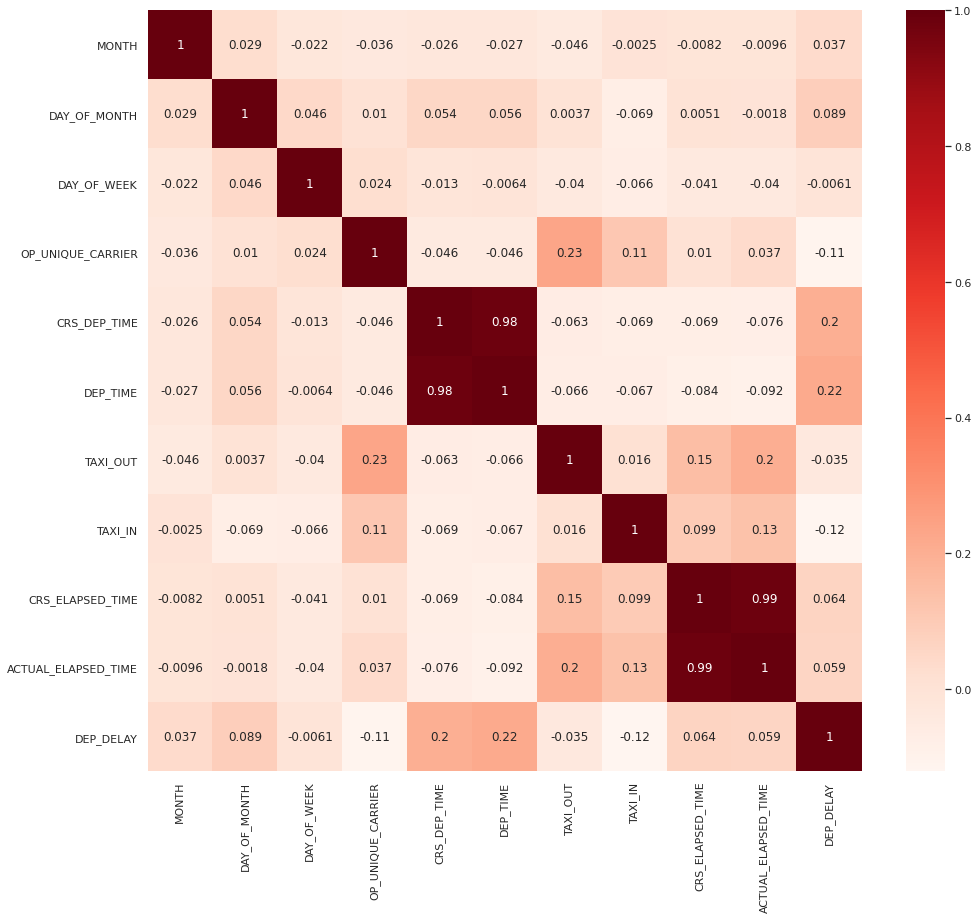

In [ ]:
#Using Pearson Correlation and vizualizing
plt.figure(figsize=(16,14))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(cor["DEP_DELAY"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

DEP_DELAY    1.0
Name: DEP_DELAY, dtype: float64

In [ ]:
X = df.drop("DEP_DELAY",1)
X
y=df["DEP_DELAY"]
y
df

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE
0,2016,9.0,28.0,3.0,0,0,3837.0,0,0,1055.0,1047.0,-8.0,9.0,7.0,1214.0,1155.0,0.0,0.0,79.0,68.0,52.0,2.0
1,2016,4.0,14.0,4.0,1,1,696.0,1,1,705.0,700.0,-5.0,13.0,7.0,810.0,802.0,0.0,0.0,65.0,62.0,42.0,1.0
2,2016,6.0,6.0,1.0,2,2,2504.0,2,2,1931.0,1927.0,-4.0,17.0,5.0,1930.0,1924.0,0.0,0.0,59.0,57.0,35.0,1.0
3,2016,2.0,24.0,3.0,2,3,1680.0,2,3,1110.0,1108.0,-2.0,25.0,9.0,1338.0,1314.0,0.0,0.0,328.0,306.0,272.0,9.0
4,2016,5.0,6.0,5.0,1,4,1570.0,3,4,730.0,724.0,-6.0,11.0,11.0,1025.0,1021.0,0.0,0.0,175.0,177.0,155.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2016,11.0,28.0,1.0,2,873,2128.0,28,11,1025.0,1023.0,-2.0,15.0,8.0,1307.0,1255.0,0.0,0.0,162.0,152.0,129.0,4.0
986,2016,8.0,28.0,7.0,3,874,1.0,43,4,1056.0,1057.0,1.0,31.0,6.0,1357.0,1401.0,0.0,0.0,181.0,184.0,147.0,5.0
987,2016,3.0,6.0,7.0,11,875,572.0,11,14,1200.0,1156.0,-4.0,16.0,3.0,1418.0,1418.0,0.0,0.0,138.0,142.0,123.0,4.0
988,2016,9.0,14.0,3.0,7,876,293.0,43,8,1720.0,1714.0,-6.0,17.0,7.0,2035.0,2019.0,0.0,0.0,375.0,365.0,341.0,10.0


In [ ]:
#Feature selection
model = LinearRegression()#Initializing RFE model
rfe = RFE(model, 7)#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  #Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True  True False False False False  True  True False
  True False False False False False False False False]
[15  1  1  1  1 11 10  5  6  1  1  2  1 12  7 14 13  3  4  8  9]


In [ ]:
#Feature selection
nof_list=np.arange(1,21)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
cols = list(X.columns)
model = LinearRegression()#Initializing RFE model
rfe = RFE(model, 10)             #Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  #Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Optimum number of features: 9
Score with 9 features: 0.382692
Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME'],
      dtype='object')


In [ ]:
df=df[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER','CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','DEP_DELAY']]
df
df.to_csv('data.csv')

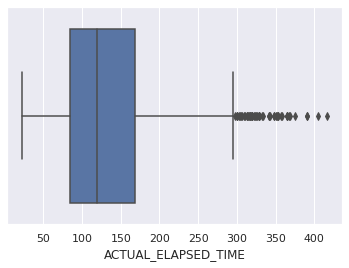

In [ ]:
#Finding outliers
sns.boxplot(x=df['ACTUAL_ELAPSED_TIME'])

In [ ]:
#Outliers removal
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df = df[~((df < (Q1-1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape
df
df.to_csv('data.csv')

MONTH                    6.0
DAY_OF_MONTH            15.0
DAY_OF_WEEK              4.0
OP_UNIQUE_CARRIER        6.0
CRS_DEP_TIME           820.0
DEP_TIME               816.0
TAXI_OUT                 8.0
TAXI_IN                  5.0
CRS_ELAPSED_TIME        82.0
ACTUAL_ELAPSED_TIME     85.0
DEP_DELAY               12.0
dtype: float64


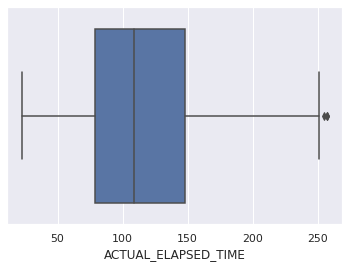

In [ ]:
sns.boxplot(x=df['ACTUAL_ELAPSED_TIME'])

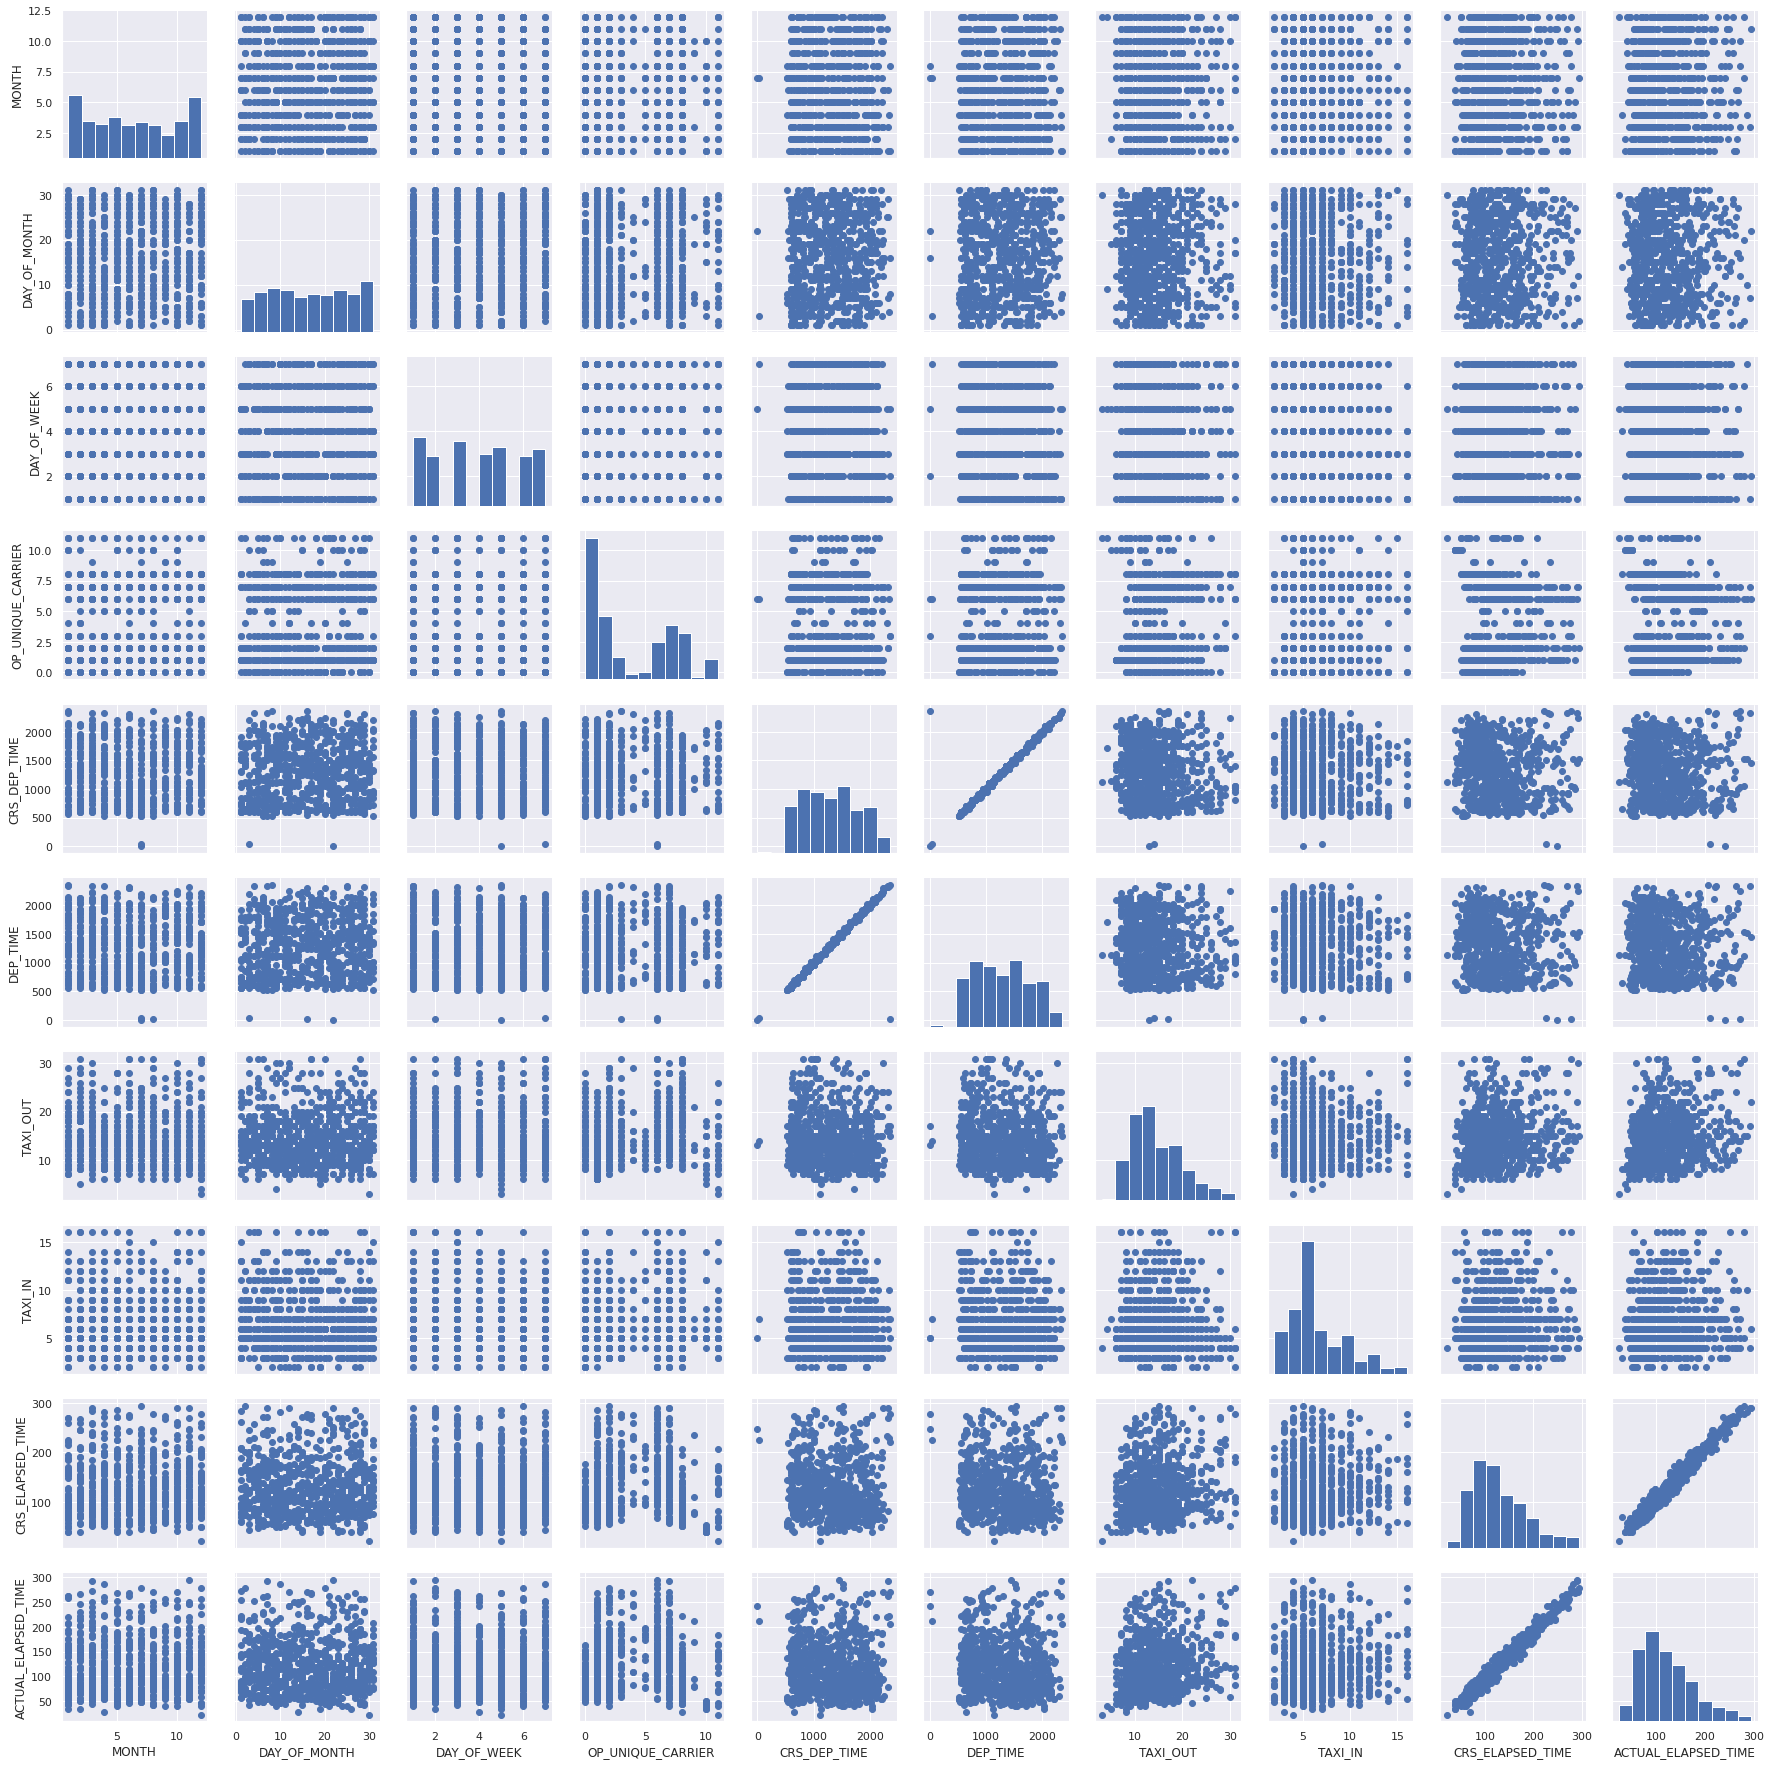

In [ ]:
#determine the basic relationship among variable
g = sns.PairGrid(df[[ 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER','CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'TAXI_IN', 'CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME']])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

#регрессия 2

Numpy edition (only for testing)

In [ ]:
class Linreg_MSE:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept

    def fit(self, X, y):     
        n, m = X.shape
        
        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        # w = (XT*X)−1*XT*Y
        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y 

        return self
        
    def predict(self, X):
        n, m = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))

        y_pred = X_train @ self.w
        return y_pred
    
    def get_weights(self):
        return self.w

class Linreg_Gradient(Linreg_MSE):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None
    
    def fit(self, X, y, lr=0.01, max_iter=100):
        n, k = X.shape

        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
        
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"
            self.w -= lr * grad

        return self

    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad

    def get_losses(self):
        return self.losses

class Linreg_SGD(Linreg_Gradient):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.n_sample = n_sample

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        grad = grad.mean(axis=0)

        return grad

#AdaGrad
class Linreg_AdaGrad(Linreg_SGD):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100, eps = 1e-6):
        n, k = X.shape

        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
        
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        gti = np.zeros(k + 1 if self.fit_intercept else k)

        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"


            gti += grad**2
            adj_grad = grad / np.sqrt(gti + eps)
            self.w -= lr * adj_grad

        return self

#RMSProp
class Linreg_RMSProp(Linreg_SGD):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100, beta = 0.6, eps = 1e-8):
        n, k = X.shape

        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
        
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        gti = np.zeros(k + 1 if self.fit_intercept else k)

        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"

            gti = beta * gti + (1-beta) * grad**2
            adj_grad = grad / np.sqrt(gti + eps)
            self.w -= lr * adj_grad

        return self

#Adam
class Linreg_Adam(Linreg_SGD):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = None

    def fit(self, X, y, lr=0.01, max_iter=100, beta1 = 0.9, beta2 = 0.99, eps = 1e-8):
        n, k = X.shape

        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
        
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X
        
        m_w = np.zeros(k + 1 if self.fit_intercept else k)
        v_w = np.zeros(k + 1 if self.fit_intercept else k)

        self.losses = []
        
        for iter_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(MSE(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f"gradient shape {grad.shape} is not equal weight shape {self.w.shape}"

            m_w = beta1 * m_w + (1-beta1) * grad
            v_w = beta2 * v_w + (1-beta2) * grad**2
            m_w /= 1-beta1**(iter_num+1)
            v_w /= 1-beta2**(iter_num+1)
            self.w -= lr * m_w/np.sqrt(v_w + eps)

        return self

#L1
class Linreg_L1(Linreg_SGD):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        signw = np.sign(self.w)
        if self.fit_intercept:
            signw[-1] = 0

        grad = X[inds].T @ (y_pred[inds] - y[inds])[:, np.newaxis] / self.n_sample
        grad += self.alpha * signw[:, np.newaxis]

        return grad.flatten()

#L2
class Linreg_L2(Linreg_SGD):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) 
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        lambdaI = self.alpha * np.eye(self.w.shape[0])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaI) @ self.w
        grad -= 2 * X[inds].T @ y[inds] / self.n_sample

        return grad

# MSE
def MSE(pred, test):
    return np.mean((pred-test)**2)


#R2
def R2(pred, test):
    mean_test = np.full_like(test, np.mean(test))
    return 1 - np.mean((pred - test)**2)/np.mean((pred - mean_test)**2)

#Данные к графикам

In [ ]:
Z = df1.to_numpy()
Z = np.array(Z[0:120,:], dtype=np.float64)
X, Y = np.delete(Z,[7],1), Z[:,7]


In [ ]:
#Dummy_data (used for testing methods)
def linear_expression(x):
    return 5 * x + 6

objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, train_size=0.7)

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, train_size=0.7)

In [ ]:
X_train = matr.fromList(np.array(X_train1, dtype=np.float128).tolist()) 
X_test =  matr.fromList(np.array(X_test1, dtype = np.float128).tolist())
y_train = matr.fromList([np.array(y_train1, dtype = np.float128).tolist()]) 
y_test = matr.fromList([np.array(y_test1, dtype = np.float128).tolist()])

In [ ]:
#numpy
X_train, X_test, y_train, y_test = X_train1, X_test1, y_train1, y_test1

#Интересные графики

0.015693395496876200894 0.02695429502012439537 0.013704383364973005398 -0.12107178615274519792 -0.26758753448091568208 0.2682926941720144045 0.044905437260403926296 -0.13666500629054828397 0.044829191198288279684 -0.039182831993286521922 -1.9620408545155009775

<bound method matr.shape of <__main__.matr object at 0x7f41687d9d68>>
Train MSE:  26.701142971216160558
Test MSE:  1857.5659142872250144
Train R2:  0.52701665062709443337
Test R2:  -24.485404014828977996


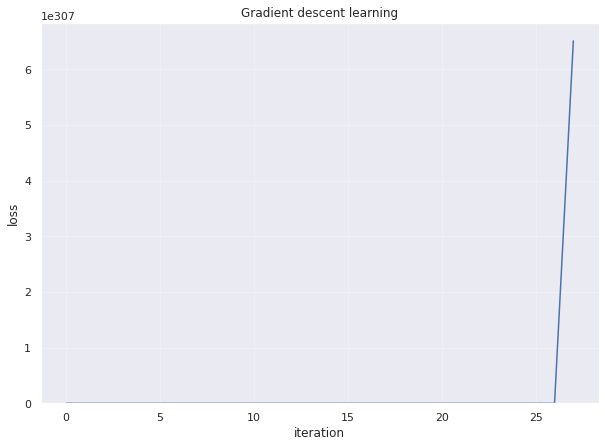

Train MSE:  2.5401718297983861986e+1119
Test MSE:  2.6775427895552866217e+1119
Train R2:  -0.13135175839079474335
Test R2:  -0.13647284867918358623


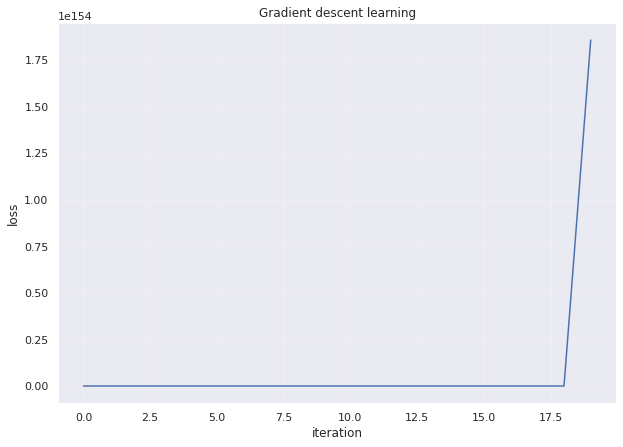

Train MSE:  9.894273693322037371e+161
Test MSE:  1.0429324816389187024e+162
Train R2:  -0.1311687604669794098
Test R2:  -0.13629185224875008261


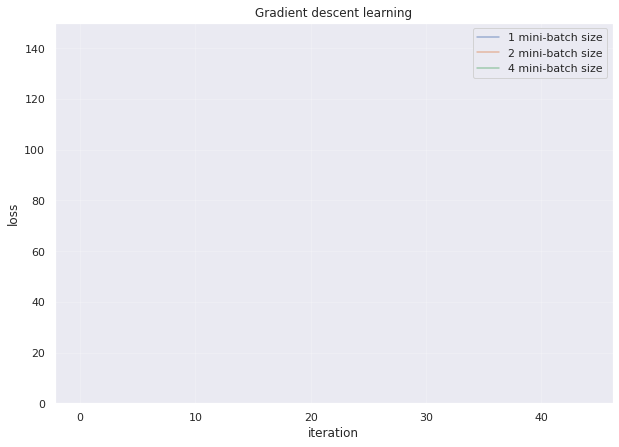

Train MSE:  9.894273693322037371e+161
Test MSE:  1.0429324816389187024e+162
Train R2:  -0.1311687604669794098
Test R2:  -0.13629185224875008261
Adagrad
w =  6.4012730140753428 8.397378127468997851 3.3957304166885931092 -0.5849556478735436325 8.395732956624956419 5.3958210461790489555 5.399199067643641832 7.4005446733943964946 8.399366076676861212 5.399485308178834971 8.39051014658423019



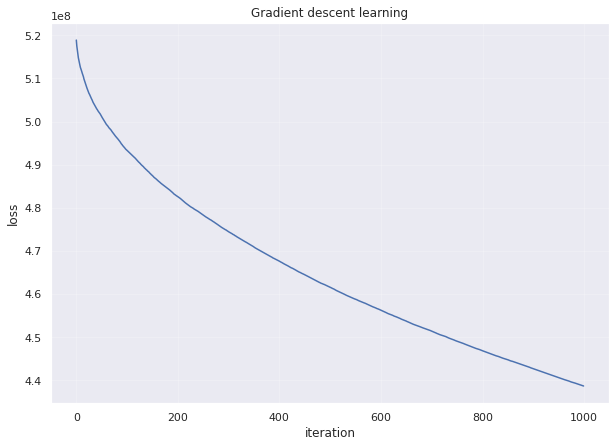

Train MSE:  438636717.39863691592
Test MSE:  461605303.66553364779
Train R2:  -0.10625851847563084964
Test R2:  -0.11188505630330792
RMSProp


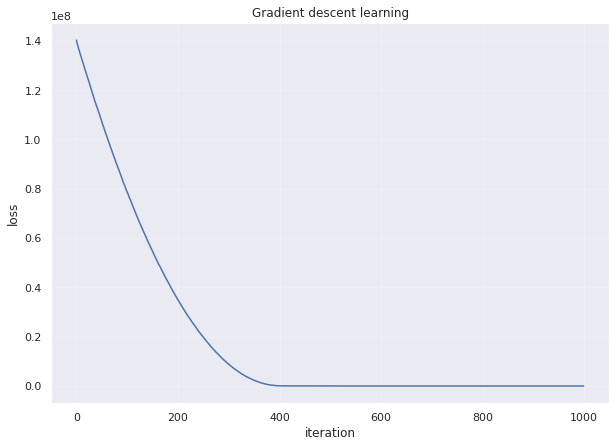

Train MSE:  5325.098729919896542
Test MSE:  222762.87845360458684
Train R2:  -2.7655478762195890878
Test R2:  -37.134508351539627338
Adam


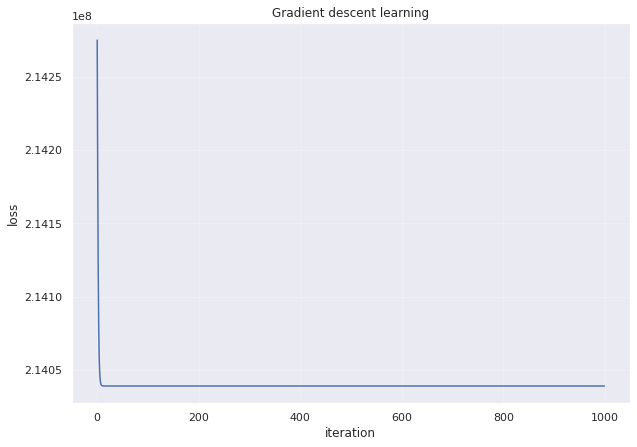

Train MSE:  214038922.483891955
Test MSE:  224632034.17107788927
Train R2:  -0.11605747049836135222
Test R2:  -0.12229931733525870583
L1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in longdouble_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: RuntimeWarning: overflow encountered in longdouble_scalars


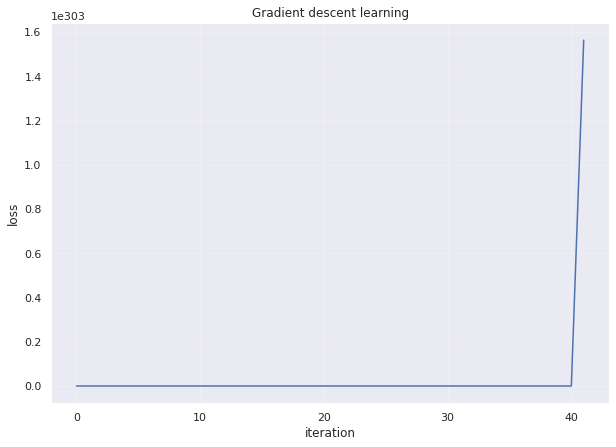

Train MSE:  inf
Test MSE:  inf
Train R2:  nan
Test R2:  nan
L2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in longdouble_scalars


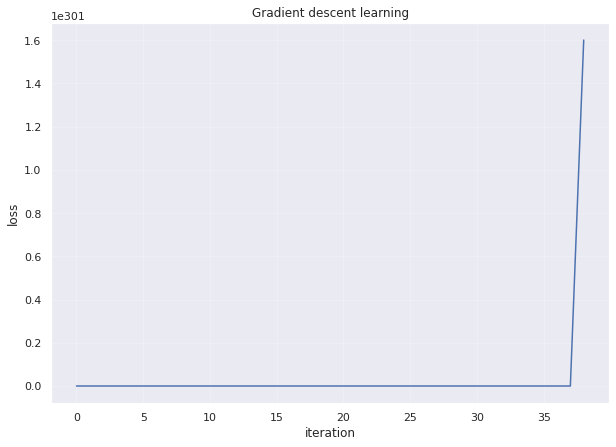

Train MSE:  inf
Test MSE:  inf
Train R2:  nan
Test R2:  nan


In [41]:
'''plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
regressor = Linreg_MSE()

regressor.fit(X_train, y_train)

predictions = regressor.predict(X_test)
w = regressor.get_weights()
print(w)
print(w.shape)
'''
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()
'''
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)

#metrics
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))

#Gradient
regressor = Linreg_Gradient(fit_intercept=True)

l = regressor.fit(X_train, y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test)
w = regressor.get_weights()
'''
plt.figure(figsize=(10, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
plt.figure(figsize=(10, 7))

#loss func
plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))
#SGD
regressor = Linreg_SGD(fit_intercept=True)

l = regressor.fit(X_train, y_train, max_iter=20).get_losses()

predictions = regressor.predict(X_test)
w = regressor.get_weights()
'''
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))
#SGD
n_samples = [1, 2, 4]
plt.figure(figsize=(10, 7))

for ns in n_samples:
    l = Linreg_SGD(fit_intercept=True, n_sample=ns).fit(
        X_train,
        y_train,
        lr=5e-3,
        max_iter=150,
    ).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))
#adagrad
print("Adagrad")
regressor = Linreg_AdaGrad(fit_intercept=True)

l = regressor.fit(X_train, y_train, max_iter=1000).get_losses()

predictions = regressor.predict(X_test)
w = regressor.get_weights()
'''
plt.figure(figsize=(10, 7))
plt.title('AdaGrad')
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))
#RMSProp
print("RMSProp")
regressor = Linreg_RMSProp(fit_intercept=True)

l = regressor.fit(X_train, y_train, max_iter=1000).get_losses()

predictions = regressor.predict(X_test)
w = regressor.get_weights()
'''
plt.figure(figsize=(10, 7))
plt.title('RMSProp')
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))
#Adam
print("Adam")
regressor = Linreg_Adam(fit_intercept=True)

l = regressor.fit(X_train, y_train, max_iter=1000).get_losses()

predictions = regressor.predict(X_test)
w = regressor.get_weights()

'''
plt.figure(figsize=(10, 7))
plt.title('Adam')
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))

print("L1")
regressor = Linreg_L1(fit_intercept=True)

l = regressor.fit(X_train, y_train, max_iter=1000).get_losses()

predictions = regressor.predict(X_test)
w = regressor.get_weights()

'''
plt.figure(figsize=(10, 7))
plt.title('Adam')
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))

print("L2")
regressor = Linreg_L2(fit_intercept=True)

l = regressor.fit(X_train, y_train, max_iter=1000).get_losses()

predictions = regressor.predict(X_test)
w = regressor.get_weights()

'''
plt.figure(figsize=(10, 7))
plt.title('Adam')
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()
'''
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()
train_predictions = regressor.predict(X_train)
test_predictions = regressor.predict(X_test)
print('Train MSE: ', MSE(y_train, train_predictions))
print('Test MSE: ', MSE(y_test, test_predictions))
print('Train R2: ', R2(y_train, train_predictions))
print('Test R2: ', R2(y_test, test_predictions))